In [14]:
# Libraries
import os
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import tensorflow as tf
from numpy import argmax
import matplotlib.pyplot as plt
%matplotlib inline
import librosa
import librosa.display
import IPython.display as Ipd
import random
import warnings
from PIL import Image
import pathlib
import csv

import sklearn
from sklearn.model_selection import train_test_split

import keras
from keras import layers
from keras.layers import Activation, Dense, Dropout, Conv2D, Flatten, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling1D, AveragePooling2D, Input, Add
from keras.models import Sequential
from keras.optimizers import SGD
import seaborn

In [15]:
# We define a specific seed so that results are repeatable:
from numpy.random import seed
from tensorflow.random import set_seed
seed(0)
set_seed(0)

# Creating a basic neural network

In this project, we will compare two methods of classifying music. Method 1 will involve a standard neural network (NN), where we preprocess the audio data to calculate numerical values of common features, and then use these values as input variables for our neural network classification algorithm. Method 2 will involve a convolutional neural network (CNN). We will input 3 variables taken from the 3D array image data of the audio in spectogram form. The first method uses more unique classes of features, while the second requires less preprocessing as it less features, but is more detailed in that it processes image data pixel-by-pixel. Let us train and test a model for each method and compare the results to see which is more efficient.

## Audio Analysis:

We will use Librosa to calculate measurements of features of the audio files and collect the means and variances of these values into a dataframe. We repeat this for each of the audio files in our dataset. We demonstrate how we calculate each feature below using our jazz.00035.wav file as an example.

In [16]:
# Note to reader: Change the path variable to suit the location of the dataset file on your device.
path = 'C:/Users/Joshua/Documents/University/Year-3/Intro-to-AI/Data'

# We use Librosa to calculate the amplitude (y) and frequency (sampling rate (sr)) of the sound waves in our audio file.
y, sr = librosa.load(f'{path}/genres_original/jazz/jazz.00035.wav')

print('y:', y, '\n')
print('y shape:', np.shape(y), '\n')
print('Sample Rate (KHz):', sr, '\n')

# Assert that our data is correct by using it to calculate the length of our audio file and verifying that it is ~30 seconds.
calc_length = np.shape(y)[0]/sr
np.testing.assert_almost_equal(actual = calc_length, desired = 30, decimal = 2, verbose=True)

# Trim y to remove leading and trailing silence if it exists, and define this to be the sample that we will work with.
sample = np.array(librosa.effects.trim(y))[0]

print("Sample (trimmed y):", sample)

y: [-0.03414917 -0.04660034 -0.02764893 ... -0.01467896 -0.02035522
 -0.01965332] 

y shape: (661794,) 

Sample Rate (KHz): 22050 

Sample (trimmed y): [-0.03414917 -0.04660034 -0.02764893 ... -0.01467896 -0.02035522
 -0.01965332]


## Zero Crossing Rate:
- The rate at which a signal changes from positive to negative or negative to positive. Can be interpreted as a measure of noisiness of a signal.



In [17]:
# Using our jazz sample:
y, sr = librosa.load(f'{path}/genres_original/jazz/jazz.00035.wav')
sample = np.array(librosa.effects.trim(y))[0]

zero_crossings = librosa.zero_crossings(sample, pad=False)
print(sum(zero_crossings))

25006


## Harmonic and percussive decomposition:
- Decomposing our audio time series into its harmonic and percussive parts.

Text(0, 0.5, 'Amplitude')

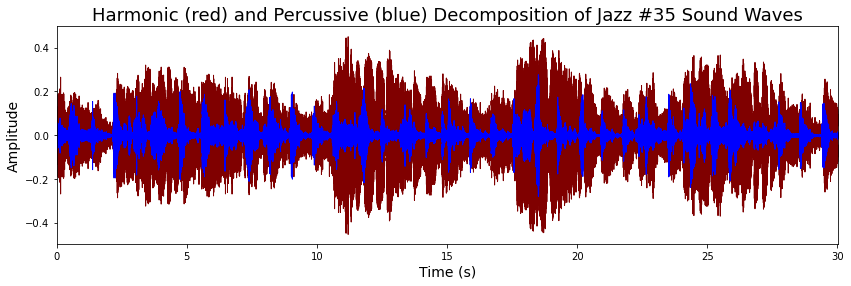

In [18]:
y_harmonic, y_percussive = librosa.effects.hpss(sample)

plt.figure(figsize = (14, 4))
librosa.display.waveplot(y = y_harmonic, sr = sr, color = "maroon");
librosa.display.waveplot(y = y_percussive, sr = sr, color = "blue");
plt.title("Harmonic (red) and Percussive (blue) Decomposition of Jazz #35 Sound Waves", fontsize = 18);
plt.xlabel("Time (s)", fontsize = 14)
plt.ylabel("Amplitude", fontsize = 14)

## Tempo (BPM):
- Pace of the beat

In [19]:
tempo = librosa.beat.beat_track(sample, sr = sr)[0]
tempo

71.77734375

## Spectral Centroid:
- Identifies where the "centre of mass" of a spectrum is located; more specifically, it is the weighted mean of the frequencies present in the signal.

Text(0, 0.5, 'Amplitude')

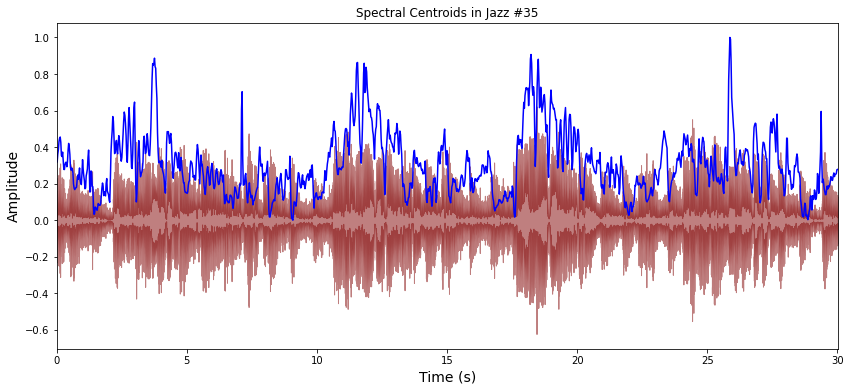

In [20]:
spectral_centroids = librosa.feature.spectral_centroid(sample, sr=sr)[0]

frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)

# Function that normalizes the Sound Data
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)

#Plotting the Spectral Centroid along the waveform
plt.figure(figsize = (14, 6))
librosa.display.waveplot(sample, sr=sr, alpha=0.5, color = 'maroon');
plt.plot(t, normalize(spectral_centroids), color='blue');
plt.title('Spectral Centroids in Jazz #35')
plt.xlabel('Time (s)', fontsize = 14)
plt.ylabel('Amplitude', fontsize = 14)

## Spectral Rolloff:
- The frequency below which a specified percentage of the total spectral energy lies.

Text(0, 0.5, 'Amplitude')

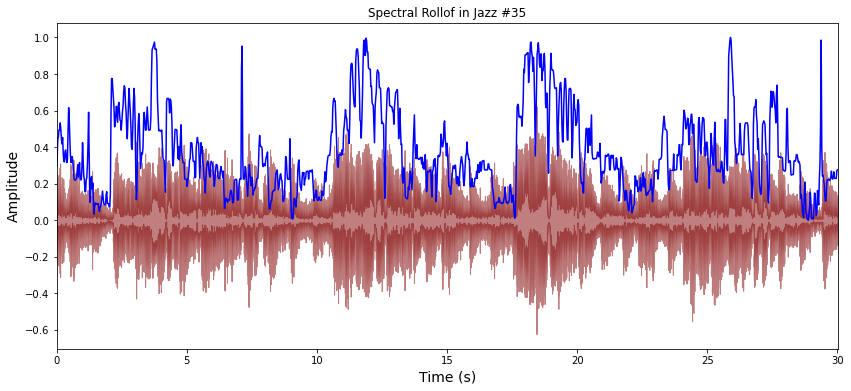

In [21]:
plt.figure(figsize = (14,6))
spectral_rolloff = librosa.feature.spectral_rolloff(sample, sr=sr)[0]
librosa.display.waveplot(sample, sr=sr, alpha=0.5, color = 'maroon')
plt.plot(t, normalize(spectral_rolloff), color='blue')
plt.title('Spectral Rollof in Jazz #35')
plt.xlabel('Time (s)', fontsize = 14)
plt.ylabel('Amplitude', fontsize = 14)

## Mel-Frequency Cepstral Coefficients:

A Mel-frequency cepstrum (MFC) represents the short-term power spectrum of a signal. It is composed of (in our case) 20 Mel-frequency cepstrum coefficiencts (MFCCs).

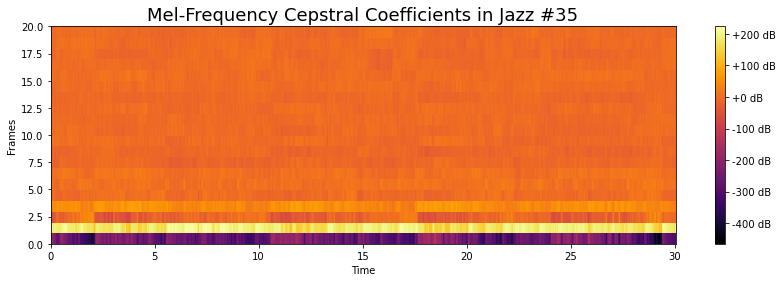

In [22]:
mfccs = librosa.feature.mfcc(sample, sr=sr, n_mfcc=20)
plt.figure(figsize = (14, 4))
librosa.display.specshow(mfccs, sr=sr, x_axis='time', y_axis = 'frames', cmap = 'inferno');
plt.title('Mel-Frequency Cepstral Coefficients in Jazz #35', fontsize = 18);
plt.colorbar(format='%+2.0f dB');

Mean: -5.9005373e-10
Variance: 1.0


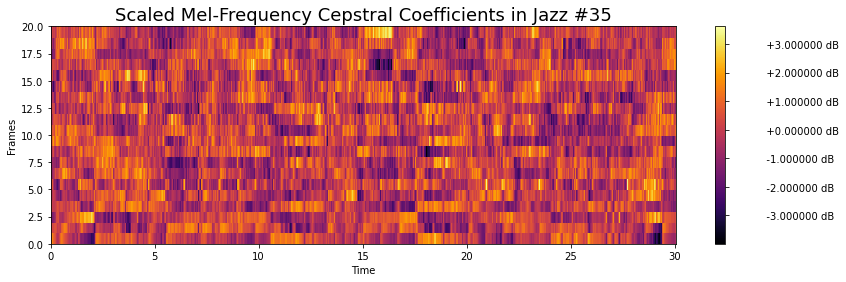

In [23]:
# We scale the data to have variance of 1.
mfccs = sklearn.preprocessing.scale(mfccs, axis=1)
print('Mean:', mfccs.mean())
print('Variance:', mfccs.var())

plt.figure(figsize = (14, 4))
librosa.display.specshow(mfccs, sr=sr, x_axis='time',y_axis = 'frames', cmap = 'inferno');
plt.title('Scaled Mel-Frequency Cepstral Coefficients in Jazz #35', fontsize = 18);
plt.colorbar(format='%+20f dB');

## Chroma Features:
Chroma features are a visual representation of audio in which the entire spectrum is projected onto 12 bins, where each bin represets one of the 12 distinct semitones of the musical octave.

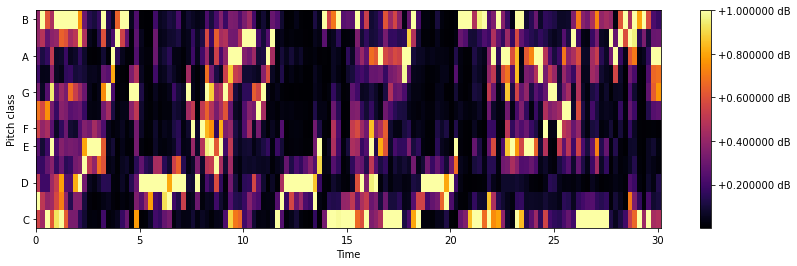

In [24]:
# Define hop length (number of samples between successive frames):
hop_length = 5000

chromagram = librosa.feature.chroma_stft(sample, sr=sr, hop_length=hop_length)
plt.figure(figsize=(14, 4))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='inferno');
plt.colorbar(format='%+0f dB');

## Creating a Deep Neural Network

In [25]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE

from keras.utils import to_categorical

We begin by collecting our data into a useful format for input into our neural network. For increased precision we split each audio file into 3 second segments. We then found the mean and variance of the numerical values of each of the features described above for each 3 second audio clip. Then, we append each set of data into a database contained in a csv file. This has already been done and we simply import the csv file below.

In [26]:
data = pd.read_csv(f'{path}/features_3_sec.csv')
data = data.iloc[0:, 1:] 
data.head()

length  chroma_stft_mean  chroma_stft_var  rms_mean   rms_var  \
0   66149          0.335406         0.091048  0.130405  0.003521   
1   66149          0.343065         0.086147  0.112699  0.001450   
2   66149          0.346815         0.092243  0.132003  0.004620   
3   66149          0.363639         0.086856  0.132565  0.002448   
4   66149          0.335579         0.088129  0.143289  0.001701   

   spectral_centroid_mean  spectral_centroid_var  spectral_bandwidth_mean  \
0             1773.065032          167541.630869              1972.744388   
1             1816.693777           90525.690866              2010.051501   
2             1788.539719          111407.437613              2084.565132   
3             1655.289045          111952.284517              1960.039988   
4             1630.656199           79667.267654              1948.503884   

   spectral_bandwidth_var  rolloff_mean  ...  mfcc16_var  mfcc17_mean  \
0           117335.771563   3714.560359  ...   39.687145    -3.241280   
1            65671.875673   3869.682242  ...   64.748276    -6.055294   
2            75124.921716   3997.639160  ...   67.336563    -1.768610   
3            82913.639269   3568.300218  ...   47.739452    -3.841155   
4            60204.020268   3469.992864  ...   30.336359     0.664582   

   mfcc17_var  mfcc18_mean  mfcc18_var  mfcc19_mean  mfcc19_var  mfcc20_mean  \
0   36.488243     0.722209   38.099152    -5.050335   33.618073    -0.243027   
1   40.677654     0.159015   51.264091    -2.837699   97.030830     5.784063   
2   28.348579     2.378768   45.717648    -1.938424   53.050835     2.517375   
3   28.337118     1.218588   34.770935    -3.580352   50.836224     3.630866   
4   45.880913     1.689446   51.363583    -3.392489   26.738789     0.536961   

   mfcc20_var  label  
0   43.771767  blues  
1   59.943081  blues  
2   33.105122  blues  
3   32.023678  blues  
4   29.146694  blues  

[5 rows x 59 columns]

In [27]:
# We break down our database to define the input variables for our neural network.

# Input data x:
x = data.loc[:, data.columns != 'label']
# Desired output y:
y = data['label']

cols = x.columns
num_features = len(cols)
num_classes = len(np.unique(y))
print('There are ', num_features, ' input features and', num_classes, ' output classes.')

# Here we transform the variables to the optimal format.
# As we see below, y is currently an array containing the genre information for each data entry.
# We want to transform y to a 2D array with the same length as x, but with a width equal to the number of unique genres.

print("y variable pre-transform:")
print(y)

y = list(y)
y_pos1 = []

for i in y:
    index = y.index(i)
    y_pos1.append(index)
    
unique_vals = list(np.unique(y_pos1))

y_pos2 = []
        
for k in y_pos1:
    if k in unique_vals:
        index = unique_vals.index(k)
        y_pos2.append(index)

y = to_categorical(y_pos2)

print("y variable post-transform:")
print(y)

# Define the training and test split for our neural network:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)


There are  58  input features and 10  output classes.
y variable pre-transform:
0       blues
1       blues
2       blues
3       blues
4       blues
        ...  
9985     rock
9986     rock
9987     rock
9988     rock
9989     rock
Name: label, Length: 9990, dtype: object
y variable post-transform:
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [28]:
from keras import Sequential
from keras.layers import Dense
from keras.optimizers import SGD

# Normalise input data to have unit variance:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

#Now define and train our model, using a sequential layer to access tensorflow through keras:
model = Sequential()

model.add(Dense(128, input_dim = num_features, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(num_classes, activation = 'softmax'))

model.compile(loss='categorical_crossentropy', optimizer=SGD(learning_rate=0.01), metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=500)

Epoch 1/500
219/219 [==============================] - 2s 1ms/step - loss: 2.1333 - accuracy: 0.2343
Epoch 2/500
219/219 [==============================] - 0s 1ms/step - loss: 1.5969 - accuracy: 0.4259
Epoch 3/500
219/219 [==============================] - 0s 1ms/step - loss: 1.3487 - accuracy: 0.5314: 0s - loss: 1.3411 - accura
Epoch 4/500
219/219 [==============================] - 0s 1ms/step - loss: 1.1851 - accuracy: 0.5873
Epoch 5/500
219/219 [==============================] - 0s 1ms/step - loss: 1.1003 - accuracy: 0.6226
Epoch 6/500
219/219 [==============================] - 0s 1ms/step - loss: 1.0241 - accuracy: 0.6541
Epoch 7/500
219/219 [==============================] - 0s 1ms/step - loss: 0.9531 - accuracy: 0.6779
Epoch 8/500
219/219 [==============================] - 0s 1ms/step - loss: 0.9046 - accuracy: 0.6934
Epoch 9/500
219/219 [==============================] - 0s 1ms/step - loss: 0.8560 - accuracy: 0.7126
Epoch 10/500
219/219 [==============================] - 0s 1ms/

219/219 [==============================] - 0s 1ms/step - loss: 0.0371 - accuracy: 0.9975
Epoch 159/500
219/219 [==============================] - 0s 1ms/step - loss: 0.0365 - accuracy: 0.9971
Epoch 160/500
219/219 [==============================] - 0s 1ms/step - loss: 0.0356 - accuracy: 0.9976
Epoch 161/500
219/219 [==============================] - 0s 1ms/step - loss: 0.0378 - accuracy: 0.9960
Epoch 162/500
219/219 [==============================] - 0s 1ms/step - loss: 0.0345 - accuracy: 0.9974
Epoch 163/500
219/219 [==============================] - 0s 1ms/step - loss: 0.0338 - accuracy: 0.9978
Epoch 164/500
219/219 [==============================] - 0s 1ms/step - loss: 0.0315 - accuracy: 0.9972
Epoch 165/500
219/219 [==============================] - 0s 1ms/step - loss: 0.0321 - accuracy: 0.9983
Epoch 166/500
219/219 [==============================] - 0s 1ms/step - loss: 0.0306 - accuracy: 0.9980
Epoch 167/500
219/219 [==============================] - 0s 1ms/step - loss: 0.0315 - a

219/219 [==============================] - 0s 1ms/step - loss: 0.0096 - accuracy: 0.9985
Epoch 317/500
219/219 [==============================] - 0s 1ms/step - loss: 0.0093 - accuracy: 0.9990
Epoch 318/500
219/219 [==============================] - 0s 1ms/step - loss: 0.0092 - accuracy: 0.9989
Epoch 319/500
219/219 [==============================] - 0s 1ms/step - loss: 0.0096 - accuracy: 0.9988: 0s - loss: 0.0097 - accuracy: 0.99
Epoch 320/500
219/219 [==============================] - 0s 1ms/step - loss: 0.0088 - accuracy: 0.9995
Epoch 321/500
219/219 [==============================] - 0s 1ms/step - loss: 0.0085 - accuracy: 0.9991
Epoch 322/500
219/219 [==============================] - 0s 1ms/step - loss: 0.0098 - accuracy: 0.9982
Epoch 323/500
219/219 [==============================] - 0s 1ms/step - loss: 0.0087 - accuracy: 0.9992
Epoch 324/500
219/219 [==============================] - 0s 1ms/step - loss: 0.0086 - accuracy: 0.9988
Epoch 325/500
219/219 [============================

219/219 [==============================] - 0s 1ms/step - loss: 0.0049 - accuracy: 0.9993
Epoch 474/500
219/219 [==============================] - 0s 1ms/step - loss: 0.0052 - accuracy: 0.9993
Epoch 475/500
219/219 [==============================] - 0s 1ms/step - loss: 0.0040 - accuracy: 0.9996
Epoch 476/500
219/219 [==============================] - 0s 1ms/step - loss: 0.0062 - accuracy: 0.9988
Epoch 477/500
219/219 [==============================] - 0s 1ms/step - loss: 0.0046 - accuracy: 0.9993
Epoch 478/500
219/219 [==============================] - 0s 1ms/step - loss: 0.0062 - accuracy: 0.9982
Epoch 479/500
219/219 [==============================] - 0s 1ms/step - loss: 0.0055 - accuracy: 0.9993
Epoch 480/500
219/219 [==============================] - 0s 1ms/step - loss: 0.0053 - accuracy: 0.9987: 0s - loss: 0.0068 - accuracy
Epoch 481/500
219/219 [==============================] - 0s 1ms/step - loss: 0.0043 - accuracy: 0.9992
Epoch 482/500
219/219 [==============================] - 

In [29]:
# Now we will test the model:
loss, accuracy = model.evaluate(x_test, y_test)
print("Loss:", loss)
print("Accuracy:", accuracy)

94/94 [==============================] - 0s 1ms/step - loss: 0.6882 - accuracy: 0.8755
Loss: 0.6882120370864868
Accuracy: 0.8755422234535217


Text(0, 0.5, 'Loss')

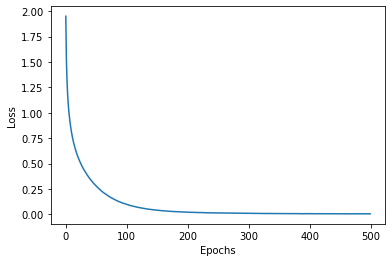

In [30]:
# Plot a graph of loss over time:
plt.plot(history.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')

Text(0, 0.5, 'Accuracy')

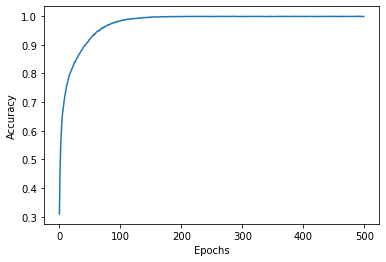

In [31]:
# Plot a graph of accuracy over time:
plt.plot(history.history['accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

## Princpal Component Analysis on genres

In [133]:
from sklearn import preprocessing

# Working with the characteristics dataset for our 30 second audio files:
data = pd.read_csv(f'{path}/features_30_sec.csv')
data = data.iloc[0:, 1:]
x = data.loc[:, data.columns != 'label']
y = data['label']


# Normalise data
scaler = StandardScaler()
x_scaled = min_max_scaler.fit_transform(x)
x = pd.DataFrame(x_scaled, columns = x.columns)


# Principal Component Analysis
from sklearn.decomposition import PCA

principal_components = PCA(n_components=2).fit_transform(x)
principal_dataframe = pd.DataFrame(data = principal_components, columns = ['principal component 1', 'principal component 2'])
dataframe = pd.concat([principal_dataframe, y], axis = 1)

Text(0, 0.5, 'Principal Component 2')

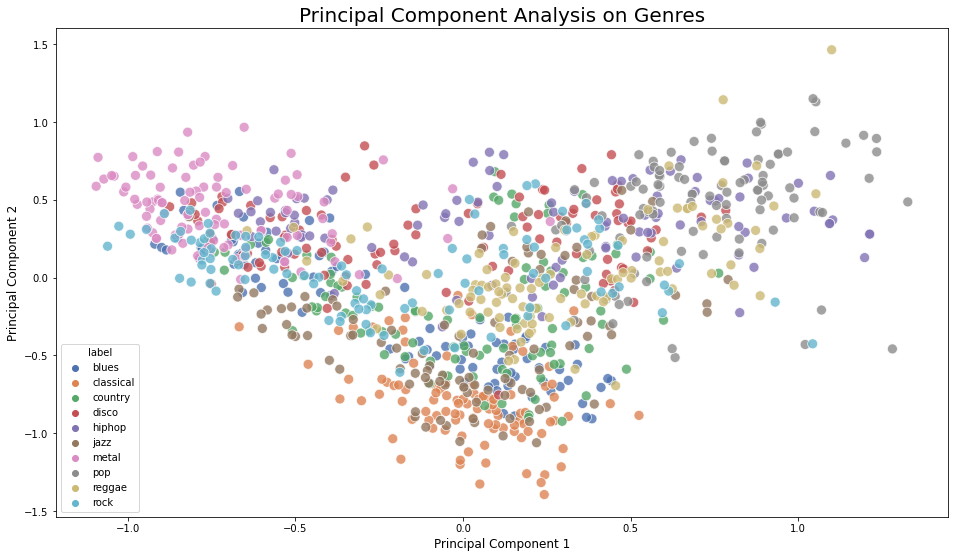

In [134]:
import seaborn as sns

plt.figure(figsize = (16, 9))
sns.set_palette("deep")
sns.scatterplot(x = "principal component 1", y = "principal component 2", hue = "label", data = dataframe , alpha = 0.8,
               s = 100);

plt.title('Principal Component Analysis on Genres', fontsize = 20)
plt.xlabel("Principal Component 1", fontsize = 12)
plt.ylabel("Principal Component 2", fontsize = 12)

## Predicting genre weighting:

To make a model that predicts the probability weighting of an audio file we can use the method below. As our sample is taken from the csv file used to train the neural network it's weighted heavily to the relevant genre. The issue here is that in order to predict the genre of a new audio file, we would have to create a function that calculated the normalised mean and variance of each feature of the song, which is inefficient. CNNs are advantageous in this regard, because they only need the spectogram image file as input, which is easier to preprocess than defining a function to calculate all of our input variables.


In [33]:
sample = x[0:1]
print("Sample:")
print(sample)
prediction = model.predict(sample, batch_size = 1)
print("Prediction:")
print(prediction)

Sample:
   length  chroma_stft_mean  chroma_stft_var  rms_mean   rms_var  \
0   66149          0.335406         0.091048  0.130405  0.003521   

   spectral_centroid_mean  spectral_centroid_var  spectral_bandwidth_mean  \
0             1773.065032          167541.630869              1972.744388   

   spectral_bandwidth_var  rolloff_mean  ...  mfcc16_mean  mfcc16_var  \
0           117335.771563   3714.560359  ...    -2.853603   39.687145   

   mfcc17_mean  mfcc17_var  mfcc18_mean  mfcc18_var  mfcc19_mean  mfcc19_var  \
0     -3.24128   36.488243     0.722209   38.099152    -5.050335   33.618073   

   mfcc20_mean  mfcc20_var  
0    -0.243027   43.771767  

[1 rows x 58 columns]
Prediction:
[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]


# Converting Audio Files to Spectogram Form:

For our second method using a CNN, we will convert our audio files to spectogram form and then input the image data into the neural network. Let us demonstrate how we do this using an example.

## 2D Sound Waves:

In [34]:
y, sr = librosa.load(f'{path}/genres_original/jazz/jazz.00035.wav')
sample = np.array(librosa.effects.trim(y))[0]

Text(0, 0.5, 'Amplitude')

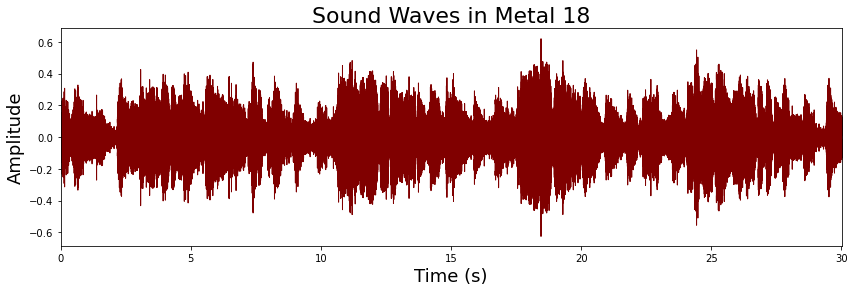

In [35]:
# We use our y and sr values to plot a graph showing the amplitude of the sound waves over time.
plt.figure(figsize = (14, 4))
librosa.display.waveplot(y = sample, sr = sr, color = "maroon");
plt.title("Sound Waves in Metal 18", fontsize = 22);
plt.xlabel("Time (s)", fontsize = 18)
plt.ylabel("Amplitude", fontsize = 18)

## Short-Time Fourier Transform

Generating a spectogram involves applying a Short-Time-Fourier-Transform (STFT) to our sample, which takes a Fourier transform at a small number of frames and calculates the amplitudes of each frequency at that point. Spanned across the entire signal results in a spectrogram of the audio.

In [36]:
# Set variables:
n_fft = 2048
hop_length = 512 

# Short-time Fourier transform (STFT):
FT = np.abs(librosa.stft(sample, n_fft = n_fft, hop_length = hop_length))

# Converting the amplitude to decibels, i.e. changing the scale 
FTDB = librosa.amplitude_to_db(FT, ref = np.max)

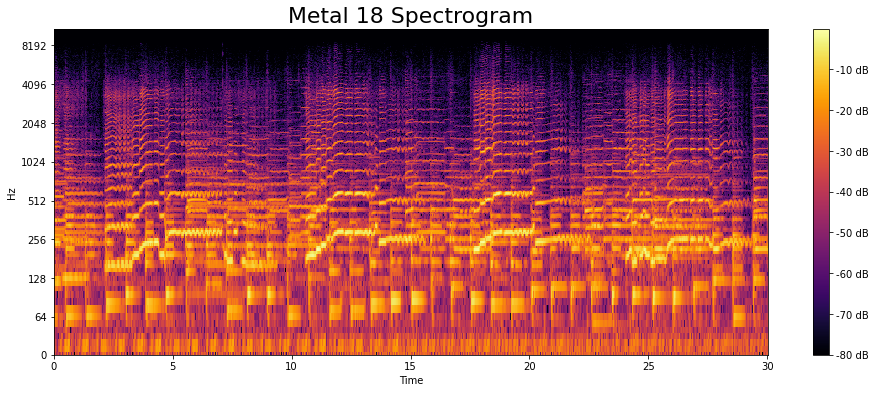

In [37]:
# Creating the Spectogram:
plt.figure(figsize = (16, 6))
librosa.display.specshow(FTDB, sr = sr, hop_length = hop_length, x_axis = 'time', y_axis = 'log', cmap = 'inferno')
plt.colorbar(format='%+2.0f dB');
plt.title("Metal 18 Spectrogram", fontsize = 22);

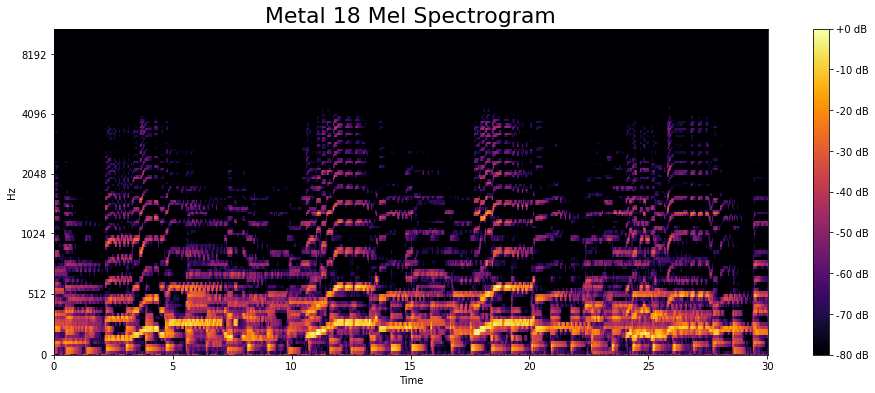

In [38]:
S = librosa.feature.melspectrogram(sample, sr=sr)
S_DB = librosa.amplitude_to_db(S, ref=np.max)
plt.figure(figsize = (16, 6))
librosa.display.specshow(S_DB, sr=sr, hop_length = hop_length, x_axis = 'time', y_axis = 'mel', cmap = 'inferno');
plt.colorbar(format='%+2.0f dB');
plt.title("Metal 18 Mel Spectrogram", fontsize = 22);

In [39]:
# Metal 18 audio file:
Ipd.Audio(f'{path}/genres_original/metal/metal.00018.wav')

Above is a typical example of a spectogram for a metal song. The brightness of the colour indicates the volume of the sound. the bright yellow at the bottom of the graph show that the lowest frequency sounds are the loudest. However, the consistent blue throughout shows that most frequencies appear in the audio all at once, except the highest frequencies. This describes the droney sound of metal.

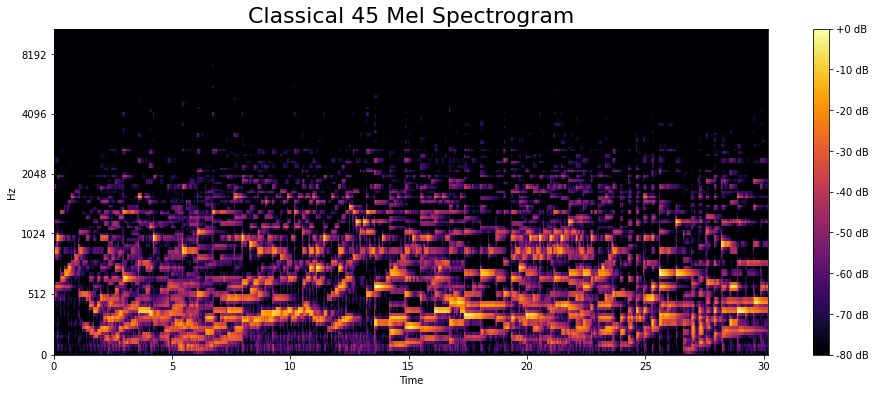

In [40]:
y, sr = librosa.load(f'{path}/genres_original/classical/classical.00045.wav')
sample = np.array(librosa.effects.trim(y))[0]

S = librosa.feature.melspectrogram(sample, sr=sr)
S_DB = librosa.amplitude_to_db(S, ref=np.max)
plt.figure(figsize = (16, 6))
librosa.display.specshow(S_DB, sr=sr, hop_length=hop_length, x_axis = 'time', y_axis = 'mel', cmap = 'inferno');
plt.colorbar(format='%+2.0f dB');
plt.title("Classical 45 Mel Spectrogram", fontsize = 22);

In [41]:
# Classical 45 audio file:
Ipd.Audio(f'{path}/genres_original/classical/classical.00045.wav')

The above spectogram of a classical music file hits more distinctive frequencies rather than being a grainy sound like the metal example. the lowest frequencies are the loudest.

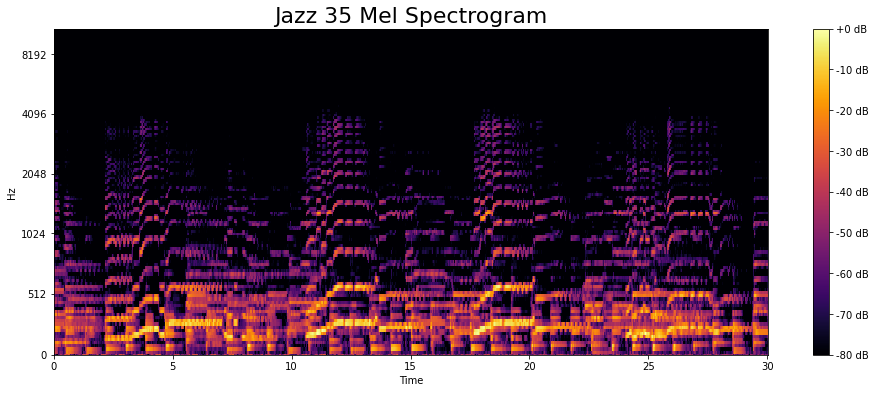

In [42]:
y, sr = librosa.load(f'{path}/genres_original/jazz/jazz.00035.wav')
sample = np.array(librosa.effects.trim(y))[0]

S = librosa.feature.melspectrogram(sample, sr=sr)
S_DB = librosa.amplitude_to_db(S, ref=np.max)
plt.figure(figsize = (16, 6))
librosa.display.specshow(S_DB, sr=sr, hop_length=hop_length, x_axis = 'time', y_axis = 'mel', cmap = 'inferno');
plt.colorbar(format='%+2.0f dB');
plt.title("Jazz 35 Mel Spectrogram", fontsize = 22);

In [43]:
# Jazz 35 audio file:
Ipd.Audio(f'{path}/genres_original/jazz/jazz.00035.wav')

Our spectogram of a typical jazz audio sample describes a more repetitive, rhythmic sound than our first two examples. We see similarities with our classical track in that the sounds are somewhat distinct, with lots of frequencies not hit.